In [1]:
# Install runtime deps for the notebook environment
!pip -q install -r requirements.txt

Check version

In [2]:
import torch, sys, platform, importlib, subprocess

def pkg_version(name):
    try:
        return importlib.import_module(name).__version__
    except Exception:
        return "not installed"

print("Python:", sys.version.split()[0], "|", platform.platform())
print("Torch:", pkg_version("torch"), "| CUDA available:", torch.cuda.is_available())
print("Sentence-Transformers:", pkg_version("sentence_transformers"))
print("Datasets:", pkg_version("datasets"))
print("scikit-learn:", pkg_version("sklearn"))
print("USearch:", pkg_version("usearch"))


Python: 3.11.13 | macOS-15.5-x86_64-i386-64bit
Torch: 2.2.2 | CUDA available: False
Sentence-Transformers: 2.6.1
Datasets: 4.4.1
scikit-learn: 1.4.2
USearch: 2.12.0


# Imports

In [3]:
import os
import sys
import re
import json
import textwrap
import pathlib
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import notebook as tqdm
from sentence_transformers import SentenceTransformer


CANDIDATE_DIRS = [
    ".",
    "/mnt/data",
    "./src",
]

os.environ["TOKENIZERS_PARALLELISM"] = "false"

added = False
for d in CANDIDATE_DIRS:
    p = pathlib.Path(d).resolve()
    if p.exists() and str(p) not in sys.path:
        sys.path.append(str(p))

print("sys.path tail:", sys.path[-3:])

# import local modules
from embeddings import Embedder
from index_usearch import VectorIndex
from engine import CodeSearchEngine

from sentence_transformers import SentenceTransformer

print("Local modules imported")


sys.path tail: ['/Users/personal/ML/ai-code-search-jb/.venv/lib/python3.11/site-packages', '/Users/personal/ML/ai-code-search-jb', '/Users/personal/ML/ai-code-search-jb/src']
Local modules imported


In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
    except Exception:
        pass

def device_str():
    import torch
    return "cuda" if torch.cuda.is_available() else "cpu"

set_seed(42)
print("Seed fixed to 42; device:", device_str())


Seed fixed to 42; device: cpu


# Part 1 — Demo of the basic embeddings-based search engine

In this part, I demonstrate that the command-line tools of my project work correctly.
We'll:
1. Create a small demo corpus of 5 code snippets in different languages.
2. Build a vector index using the CLI tool (`build_index.py`).
3. Run a query against it using the CLI tool (`engine.py`).
4. Display the retrieved results.

## Built demo indexes

In [5]:
os.makedirs("data", exist_ok=True)

demo_docs = [
    {"id": 1, "text": "def add(a, b):\n    return a + b", 
     "meta": {"func_name": "add", "lang": "python"}},
    {"id": 2, "text": "def multiply(a, b):\n    return a * b", 
     "meta": {"func_name": "multiply", "lang": "python"}},
    {"id": 3, "text": "def reverse_list(xs):\n    return xs[::-1]", 
     "meta": {"func_name": "reverse_list", "lang": "python"}},
    {"id": 4, "text": "public static int add(int a, int b){\n    return a + b;\n}", 
     "meta": {"func_name": "add", "lang": "java"}},
    {"id": 5, "text": "public static List<Integer> sortDesc(List<Integer> xs){\n    xs.sort(Comparator.reverseOrder());\n    return xs;\n}", 
     "meta": {"func_name": "sortDesc", "lang": "java"}},
]

with open("data/demo_docs.jsonl", "w", encoding="utf-8") as f:
    for d in demo_docs:
        f.write(json.dumps(d, ensure_ascii=False) + "\n")


In [6]:
!python -m src.build_index \
    --docs data/demo_docs.jsonl \
    --index data/demo_usearch.idx \
    --model sentence-transformers/all-MiniLM-L6-v2


Built index with 5 docs. Saved to data/demo_usearch.idx.


## Run a query

In [7]:
!python -m src.engine \
    --model sentence-transformers/all-MiniLM-L6-v2 \
    --index data/demo_usearch.idx \
    --query "reverse a list in python" \
    --k 3


[
  {
    "rank": 1,
    "doc_id": 3,
    "score": 0.7939775586128235,
    "text": "def reverse_list(xs):\n    return xs[::-1]",
    "meta": {
      "func_name": "reverse_list",
      "lang": "python"
    }
  },
  {
    "rank": 2,
    "doc_id": 5,
    "score": 0.44611436128616333,
    "text": "public static List<Integer> sortDesc(List<Integer> xs){\n    xs.sort(Comparator.reverseOrder());\n    return xs;\n}",
    "meta": {
      "func_name": "sortDesc",
      "lang": "java"
    }
  },
  {
    "rank": 3,
    "doc_id": 2,
    "score": 0.31570422649383545,
    "text": "def multiply(a, b):\n    return a * b",
    "meta": {
      "func_name": "multiply",
      "lang": "python"
    }
  }
]


## Results

In [8]:
eng = CodeSearchEngine(model_name="sentence-transformers/all-MiniLM-L6-v2")
with open("data/demo_docs.jsonl") as f:
    docs = [json.loads(l) for l in f]
eng.ingest(docs)
eng.idx.load("data/demo_usearch.idx")

results = eng.search("reverse a list in python", k=3)
pd.DataFrame([{
    "rank": r["rank"],
    "score": round(r["score"], 3),
    "id": r["doc_id"],
    "lang": r["meta"].get("lang", ""),
    "snippet": r["text"][:60] + "…"
} for r in results])


,rank,score,id,lang,snippet
0,1,0.794,3,python,def reverse_list(xs):\n return xs[::-1]…
1,2,0.446,5,java,public static List<Integer> sortDesc(List<Inte...
2,3,0.316,2,python,"def multiply(a, b):\n return a * b…"


# Part 2 - Evaluation on CoSQA

Check CoSQA dataset in json file 

In [9]:
! head -n 5 data/cosqa/queries.jsonl

{"qid": 0, "query": "python check relation is symmetric"}
{"qid": 1, "query": "python split strings into list of lines"}
{"qid": 2, "query": "python notify all other threads to stop"}
{"qid": 3, "query": "loading a series of images in python and resizing them"}
{"qid": 4, "query": "python use numpy array as list in code"}


## Prepare CoSQA dataset

data/cosqa/queries.jsonl -> data/cosqa/{corpus.jsonl, queries.jsonl, qrels.jsonl, train_pairs.jsonl, val_pairs.jsonl}

In [10]:
!python -m src.prepare_cosqa --out data/cosqa

100%|██████████████████████████████████████| 604/604 [00:00<00:00, 23840.69it/s]
Wrote files into: /Users/personal/ML/ai-code-search-jb/data/cosqa


In [11]:
!head -n 3 data/cosqa/corpus.jsonl
!head -n 3 data/cosqa/queries.jsonl
!head -n 3 data/cosqa/qrels.jsonl

{"doc_id": 0, "code": "def is_edge_consistent(graph, u, v):\n    \"\"\"Check if all edges between two nodes have the same relation.\n\n    :param pybel.BELGraph graph: A BEL Graph\n    :param tuple u: The source BEL node\n    :param tuple v: The target BEL node\n    :return: If all edges from the source to target node have the same relation\n    :rtype: bool\n    \"\"\"\n    if not graph.has_edge(u, v):\n        raise ValueError('{} does not contain an edge ({}, {})'.format(graph, u, v))\n\n    return 0 == len(set(d[RELATION] for d in graph.edge[u][v].values()))", "func_name": "is_edge_consistent", "lang": "python"}
{"doc_id": 1, "code": "def split_multiline(value):\n    \"\"\"Split a multiline string into a list, excluding blank lines.\"\"\"\n    return [element for element in (line.strip() for line in value.split('\\n'))\n            if element]", "func_name": "split_multiline", "lang": "python"}
{"doc_id": 2, "code": "def wait_until_exit(self):\n        \"\"\" Wait until all the thr

## Built index

In [12]:
BASE_MODEL="sentence-transformers/all-MiniLM-L6-v2"
INDEX_PATH="data/cosqa/usearch_base.idx"

!python -m src.build_index \
    --docs data/cosqa/corpus.jsonl \
    --index $INDEX_PATH \
    --model $BASE_MODEL


Built index with 604 docs. Saved to data/cosqa/usearch_base.idx.


## Evaluate

In [13]:
!python -m src.eval \
    --corpus data/cosqa/corpus.jsonl \
    --queries data/cosqa/queries.jsonl \
    --qrels data/cosqa/qrels.jsonl \
    --index $INDEX_PATH \
    --model $BASE_MODEL \
    --k 10 \
    > data/metrics_base.json

In [14]:
!cat data/metrics_base.json

{
  "Recall@10": 0.9808306709265175,
  "MRR@10": 0.8180511182108626,
  "NDCG@10": 0.8588596482035777
}


,Recall@10,MRR@10,NDCG@10
Base model (MiniLM),0.980831,0.818051,0.85886


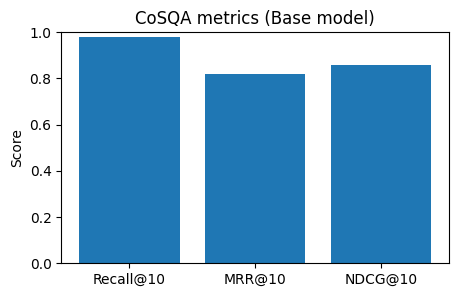

In [15]:

with open("data/metrics_base.json", "r") as f:
    base_metrics = json.load(f)

df_base = pd.DataFrame([base_metrics], index=["Base model (MiniLM)"])
display(df_base)

plt.figure(figsize=(5,3))
plt.bar(df_base.columns, df_base.iloc[0].values)
plt.title("CoSQA metrics (Base model)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.show()


# Part 3 — Fine-tuning

In this part, I am training the bi-encoder in pairs (query, code) from CoSQA using 
MultipleNegativesRankingLoss, plotting the decreasing loss and showing the improvement in metrics.

Model fine-tuned for code-text similarity using MultipleNegativesRankingLoss.

In [16]:
FINETUNED_DIR="models/cosqa-mini"
!rm -rf $FINETUNED_DIR

!python -m src.train \
  --train_pairs data/cosqa/train_pairs.jsonl \
  --val_pairs   data/cosqa/val_pairs.jsonl \
  --val_corpus  data/cosqa/corpus.jsonl \
  --val_queries data/cosqa/queries.jsonl \
  --val_qrels   data/cosqa/qrels.jsonl \
  --epochs 4 --batch_size 64 --lr 2e-5 \
  --log_every 1 \
  --out_dir models/cosqa-mini \
  --log_path data/train_log.txt


Train examples: 281, batch_size: 64
IR evaluator ready: |corpus|=604 |queries|=604
epoch=1 step=1 loss=0.361321 ema_loss=0.361321
epoch=1 step=2 loss=0.403014 ema_loss=0.363405
epoch=1 step=3 loss=0.363083 ema_loss=0.363389
epoch=1 step=4 loss=0.223441 ema_loss=0.356392
Evaluating after epoch 1 ...
epoch=2 step=5 loss=0.171893 ema_loss=0.347167
epoch=2 step=6 loss=0.222406 ema_loss=0.340929
epoch=2 step=7 loss=0.132414 ema_loss=0.330503
epoch=2 step=8 loss=0.090319 ema_loss=0.318494
Evaluating after epoch 2 ...
epoch=3 step=9 loss=0.106161 ema_loss=0.307877
epoch=3 step=10 loss=0.196699 ema_loss=0.302318
epoch=3 step=11 loss=0.151232 ema_loss=0.294764
epoch=3 step=12 loss=0.151325 ema_loss=0.287592
Evaluating after epoch 3 ...
epoch=4 step=13 loss=0.133341 ema_loss=0.279880
epoch=4 step=14 loss=0.099128 ema_loss=0.270842
epoch=4 step=15 loss=0.190287 ema_loss=0.266814
epoch=4 step=16 loss=0.148601 ema_loss=0.260904
Evaluating after epoch 4 ...
Saved to: models/cosqa-mini
Loss log writt

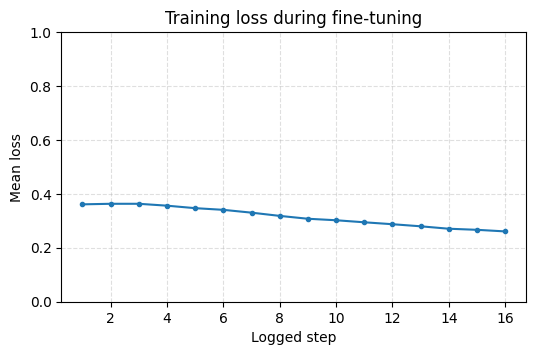

In [17]:
steps, losses = [], []
with open("data/train_log.txt", "r", encoding="utf-8", errors="ignore") as f:
    for i, line in enumerate(f, 1):
        if "loss" in line.lower():
            nums = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            if nums:
                try:
                    val = float(nums[-1])
                    losses.append(val)
                    steps.append(len(steps)+1)
                except:
                    pass

if losses:
    plt.figure(figsize=(6,3.5))
    plt.ylim(0, 1)
    plt.plot(steps, losses, marker=".")
    plt.title("Training loss during fine-tuning")
    plt.xlabel("Logged step")
    plt.ylabel("Mean loss")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.show()
else:
    print("The loss values could not be found in the log. Check the output format train.py")


# Check metrics after fitting

In [18]:
!python -m src.eval \
    --corpus  data/cosqa/corpus.jsonl \
    --queries data/cosqa/queries.jsonl \
    --qrels   data/cosqa/qrels.jsonl \
    --model   $FINETUNED_DIR \
    --k 10 \
    > data/metrics_finetuned.json

In [19]:
!cat data/metrics_finetuned.json


{
  "Recall@10": 0.9968051118210862,
  "MRR@10": 0.8755058572949945,
  "NDCG@10": 0.9063681537854873
}


,Recall@10,MRR@10,NDCG@10
Base (MiniLM),0.980831,0.818051,0.858860
Fine-tuned,0.996805,0.875506,0.906368


Relative improvement (%):


,Recall@10,MRR@10,NDCG@10
Δ%,1.63,7.02,5.53


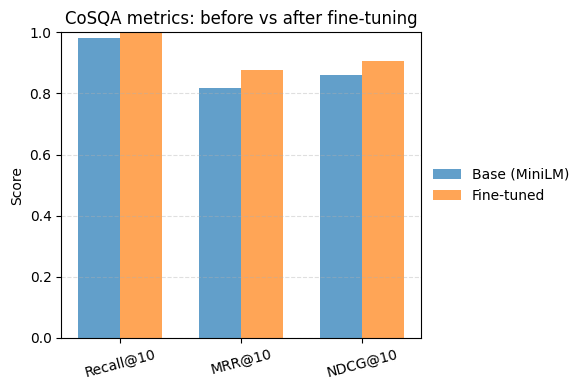

In [20]:
with open("data/metrics_base.json","r") as f:
    base = json.load(f)
with open("data/metrics_finetuned.json","r") as f:
    ft = json.load(f)

df = pd.DataFrame([base, ft], index=["Base (MiniLM)", "Fine-tuned"])
display(df)

impr = (df.loc["Fine-tuned"] - df.loc["Base (MiniLM)"]) / df.loc["Base (MiniLM)"] * 100
print("Relative improvement (%):")
display(impr.round(2).to_frame("Δ%").T)

x = np.arange(len(df.columns))
width = 0.35

plt.figure(figsize=(7,4))
plt.bar(x - width/2, df.loc["Base (MiniLM)"], width, label="Base (MiniLM)", alpha=0.7)
plt.bar(x + width/2, df.loc["Fine-tuned"], width, label="Fine-tuned", alpha=0.7)

plt.xticks(x, df.columns, rotation=15)
plt.ylabel("Score")
plt.title("CoSQA metrics: before vs after fine-tuning")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=False
)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

